# Clustering Smartphone Cases

## Preparation

In [1]:
import itertools

import numpy as np
import pandas as pd

from sklearn.metrics import adjusted_rand_score, silhouette_score

from src import akeneo, akeneo_clustering as ac, clustering, config

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
data_dir = config.dir_data / "clustering-results" / "2-phones"
data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
family = "smartphones"
channel = "default"
lang = "en_US"

### Products

In [5]:
products = ac.parse_products(
    cache,
    product_families=[family],
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

n = len(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [6]:
labels_want_generations = products_df["__categories__"].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations = len(set(labels_want_generations))
pd.Series(labels_want_generations).value_counts(), f"k = {k_generations}"

(s21    21
 s20    17
 s22     4
 dtype: int64,
 'k = 3')

In [7]:
labels_want_models = products_df["__categories__"].map(lambda x: x[-1]).to_numpy()
k_models = len(set(labels_want_models))
pd.Series(labels_want_models).value_counts(), f"k = {k_models}"

(s21          7
 s21_ultra    6
 s20          5
 s20_plus     5
 s20_ultra    4
 s21_plus     4
 s21_fe       4
 s20_fe       3
 s22          2
 s22_plus     1
 s22_ultra    1
 dtype: int64,
 'k = 11')

In [8]:
duplicates: dict[str, list[int]] = {}
for index, categories in products_df.to_dict()[ac.KEY_CATEGORIES].items():
    category = categories[0]
    if category[:4] != "dup_":
        continue

    if category not in duplicates:
        duplicates[category] = []
    duplicates[category].append(index)
duplicates

{'dup_s20': [1, 2],
 'dup_s20_ultra': [9, 10],
 'dup_s21_128': [18, 19],
 'dup_s21_256': [20, 21],
 'dup_s21_plus': [24, 25],
 'dup_s21_ultra': [32, 33]}

### Attributes

In [9]:
tmp = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required": [],
    "non-null": [],
    "unique": [],
}

attr_req = list(filter(lambda f: f.code == family, cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    typeclass = (
        "numerical"
        if attr.type in ac.TYPES_NUMERICAL
        else "categorical"
        if attr.type in ac.TYPES_CATEGORICAL
        else "multi"
        if attr.type in ac.TYPES_MULTI
        else "string"
        if attr.type in ac.TYPES_TEXT
        else "unknown"
    )

    tmp["code"].append(attr_code)
    tmp["name"].append(attr.labels[lang])
    tmp["type"].append(attr.type)
    tmp["typeclass"].append(typeclass)
    tmp["required"].append(attr_code in attr_req)
    tmp["non-null"].append(products_df[attr_code].count())
    tmp["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(tmp)
attr_df.sort_values(["required", "non-null"], ascending=[False, False])

,code,name,type,typeclass,required,non-null,unique
10,icecat_12435_fixed,Rear camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,4
11,icecat_12437_fixed,Front camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,3
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
37,icecat_1766_fixed,Product color,AttributeType.SELECT_MULTI,multi,True,42,15
64,icecat_27587,Rear camera type,AttributeType.SELECT_SINGLE,categorical,True,42,2
...,...,...,...,...,...,...,...
108,icecat_3807,Package height,AttributeType.METRIC,numerical,False,1,1
109,icecat_3808,Package width,AttributeType.METRIC,numerical,False,1,1
112,icecat_38332,Heart rate sensor,AttributeType.BOOL,categorical,False,1,1
137,icecat_4857,Battery weight,AttributeType.METRIC,numerical,False,1,1


In [10]:
cols = ["code", "typeclass", "required", "non-null", "unique"]
attr_df[cols].groupby(["typeclass", "required"]).agg({
    "code": "count",
    "non-null": ["median", "mean"],
    "unique": ["median", "mean"],
}).reset_index().round(1)

typeclass required  code non-null       unique      
                        count   median  mean median  mean
0  categorical    False    87     32.0  26.1    1.0   1.2
1  categorical     True    18     40.0  37.7    1.0   1.7
2        multi    False    19     30.0  23.1    2.0   2.9
3        multi     True     3     40.0  38.7    4.0   7.0
4    numerical    False    48     15.0  18.5    3.0   3.5
5    numerical     True     8     42.0  41.1    4.5   5.4
6       string    False     6     15.0  18.0    2.0   4.8
7       string     True     6     42.0  41.0   20.0  20.2

### Clustering & Metrics

In [11]:
def _calc_duplicates_match(labels) -> float:
    result = 0.0
    n_duplicates = 0
    for _, indexes in duplicates.items():
        y1 = labels[indexes[0]]
        y2 = labels[indexes[1]]

        shared_clusters = len(y1.intersection(y2))
        all_clusters = len(y1.union(y2))

        result += (shared_clusters+1) / all_clusters
        n_duplicates += 1
    
    return result / n_duplicates

def calc_metrics(attr_codes, multi_as_single=False, attr_to_overweight: list[str] = None, factor = 2):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    if attr_to_overweight is not None:
        dataset = ac.overweight_attributes(dataset, attr_to_overweight, factor)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_gen": adjusted_rand_score(labels_want_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_want_models, bik.labels_flat(k_models)),
        "match_dup": _calc_duplicates_match(bik.labels)
    }

In [12]:
def metrics_to_table(metric):
    matches = {
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
        "Match Duplicates": metric["match_dup"],
    }
    result = {
        "Stability": metric["stabilities"].mean(),
        "Quality": metric["qualities"].mean(),
        "Match": np.array([v for _, v in matches.items()]).mean(),
    }
    return {
        "Mean": np.array([v for _, v in result.items()]).mean(),
        **result,
        **matches,
    }

## Clusterings

### Evaluate Multi-Categorical

In [13]:
attr_codes_mul = attr_df[
    (attr_df["typeclass"] == "multi")
]["code"].to_list()
attr_codes_str = attr_df[
    (attr_df["typeclass"] == "string")
]["code"].to_list()

cols = ["code", "typeclass", "required"]
attr_df[attr_df["code"].isin(attr_codes_mul+attr_codes_str)][cols].groupby(cols[1:]).count()

code
typeclass required      
multi     False       19
          True         3
string    False        6
          True         6

In [14]:
def metrics_mul_make():
    return {
        "multi": calc_metrics(attr_codes_mul),
        "multi as single": calc_metrics(attr_codes_mul, True),
        "string as multi": calc_metrics(attr_codes_str),
        "string as single": calc_metrics(attr_codes_str, True),
    }
metrics_mul = config.load_or_create(data_dir / "metrics-mul.pkl", metrics_mul_make)

In [15]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_mul.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
multi,0.63,0.91,0.39,0.58,0.40,0.45,0.89
multi as single,0.56,0.85,0.38,0.43,0.12,0.30,0.88
string as multi,0.69,0.88,0.34,0.84,0.64,0.87,1.00
string as single,0.54,0.81,0.24,0.56,0.14,0.59,0.97


### Evaluate Type Classes

In [16]:
tmp = ["numerical", "categorical", "multi", "string"]
attr_codes_types = {
    **{
        t: attr_df[attr_df["typeclass"]==t]["code"].to_list()
        for t in tmp
    },
    **{
        f"{t1[:3]}+{t2[:3]}": attr_df[attr_df["typeclass"].isin([t1, t2])]["code"].to_list()
        for t1, t2 in itertools.combinations(tmp, 2)
    },
    **{
        f"{t1[:3]}+{t2[:3]}+{t3[:3]}": attr_df[attr_df["typeclass"].isin([t1, t2, t3])]["code"].to_list()
        for t1, t2, t3 in itertools.combinations(tmp, 3)
    },
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(tmp)]["code"].to_list(),
}
pd.DataFrame([(key, value) for key, value in attr_codes_types.items()])

,0,1
0,numerical,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
1,categorical,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
2,multi,"[icecat_13248_fixed, icecat_14695_fixed, iceca..."
3,string,"[icecat_12434, icecat_1585, icecat_1597, iceca..."
4,num+cat,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
5,num+mul,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
6,num+str,"[icecat_11379, icecat_12434, icecat_12435_fixe..."
7,cat+mul,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
8,cat+str,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
9,mul+str,"[icecat_12434, icecat_13248_fixed, icecat_1469..."


In [17]:
def metrics_types_make():
    return {
        key: calc_metrics(value)
        for key, value in attr_codes_types.items()
    }
metrics_types = config.load_or_create(data_dir / "metrics-types.pkl", metrics_types_make)

In [18]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_types.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
numerical,0.63,0.88,0.43,0.57,0.01,0.75,0.96
categorical,0.69,0.96,0.45,0.65,0.65,0.49,0.81
multi,0.63,0.91,0.39,0.58,0.40,0.45,0.89
string,0.69,0.88,0.34,0.84,0.64,0.87,1.00
num+cat,0.73,0.98,0.43,0.77,0.65,0.71,0.96
num+mul,0.65,0.94,0.39,0.62,0.16,0.70,1.00
num+str,0.62,0.93,0.38,0.56,0.01,0.67,1.00
cat+mul,0.59,0.88,0.39,0.49,0.11,0.49,0.87
cat+str,0.69,0.99,0.40,0.67,0.65,0.42,0.94
mul+str,0.63,0.93,0.36,0.60,0.15,0.66,1.00


### Evaluate Attribute Selection

#### Required

In [19]:
def metrics_types_req_make():
    return {
        key: calc_metrics(list(filter(lambda a: a in attr_req, codes)))
        for key, codes in attr_codes_types.items()
    }
metrics_types_req = config.load_or_create(data_dir / "metrics-types-req.pkl", metrics_types_req_make)

In [20]:
pd.DataFrame({
    f"{key} req": metrics_to_table(values)
    for key, values in metrics_types_req.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
numerical req,0.64,0.96,0.48,0.47,-0.04,0.48,0.97
categorical req,0.59,0.76,0.43,0.59,0.55,0.46,0.75
multi req,0.54,0.70,0.38,0.54,0.51,0.24,0.86
string req,0.62,0.94,0.37,0.55,0.17,0.53,0.96
num+cat req,0.61,0.91,0.42,0.49,-0.04,0.61,0.89
num+mul req,0.58,0.91,0.31,0.53,0.07,0.52,1.00
num+str req,0.66,1.00,0.40,0.59,-0.04,0.83,0.97
cat+mul req,0.54,0.74,0.27,0.63,0.57,0.51,0.80
cat+str req,0.64,0.93,0.36,0.64,0.47,0.54,0.90
mul+str req,0.60,0.91,0.25,0.64,0.62,0.35,0.94


#### Custom Selection

In [21]:
def metrics_attr_make():
    return {
        attr_code: calc_metrics([attr_code])
        for attr_code in attr_df["code"]
    }
metrics_attr = config.load_or_create(data_dir / "metrics-attr.pkl", metrics_attr_make)

In [22]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_attr.items()
}).transpose().round(2).sort_values("Mean", ascending=False).head(12).style.highlight_max(color= "lightgreen")

,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
icecat_13246_fixed,0.700000,0.940000,0.560000,0.600000,0.150000,0.740000,0.890000
icecat_94,0.670000,0.880000,0.530000,0.590000,-0.010000,0.870000,0.890000
icecat_1464,0.630000,0.890000,0.520000,0.470000,-0.030000,0.630000,0.820000
icecat_description_short,0.610000,0.790000,0.490000,0.560000,0.110000,0.710000,0.870000
icecat_title,0.600000,0.920000,0.290000,0.600000,0.280000,0.560000,0.960000
icecat_944,0.600000,0.840000,0.450000,0.500000,0.030000,0.690000,0.780000
icecat_17956,0.590000,0.780000,0.420000,0.590000,0.690000,0.250000,0.820000
icecat_17669_fixed,0.580000,0.780000,0.490000,0.480000,0.070000,0.480000,0.890000
icecat_36917,0.580000,0.710000,0.400000,0.640000,0.650000,0.460000,0.820000
icecat_summary_short,0.580000,0.940000,0.290000,0.500000,-0.030000,0.580000,0.970000


In [23]:
attr_codes_high_impact = ["icecat_13246_fixed", "icecat_94", "icecat_17956", "icecat_36917", "icecat_summary_short"]
attr_df[attr_df["code"].isin(attr_codes_high_impact)]

,code,name,type,typeclass,required,non-null,unique
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11
40,icecat_17956,Color name,AttributeType.TEXT,string,False,35,19
101,icecat_36917,Second rear camera field of view (FOV) angle,AttributeType.METRIC,numerical,False,31,5
184,icecat_94,Weight,AttributeType.METRIC,numerical,True,40,11
193,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,42,38


In [24]:
tmp = pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_attr.items()
}).transpose().round(2)
pd.merge(attr_df, tmp.reset_index().rename({"index": "code"}, axis=1), on="code").sort_values("Mean", ascending=False).head(20)

,code,name,type,typeclass,required,non-null,unique,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11,0.70,0.94,0.56,0.60,0.15,0.74,0.89
184,icecat_94,Weight,AttributeType.METRIC,numerical,True,40,11,0.67,0.88,0.53,0.59,-0.01,0.87,0.89
17,icecat_1464,Height,AttributeType.METRIC,numerical,False,40,11,0.63,0.89,0.52,0.47,-0.03,0.63,0.82
191,icecat_description_short,Short Description,AttributeType.TEXT,string,True,36,16,0.61,0.79,0.49,0.56,0.11,0.71,0.87
194,icecat_title,Title,AttributeType.TEXT,string,True,42,38,0.60,0.92,0.29,0.60,0.28,0.56,0.96
185,icecat_944,Display diagonal,AttributeType.METRIC,numerical,True,42,8,0.60,0.84,0.45,0.50,0.03,0.69,0.78
40,icecat_17956,Color name,AttributeType.TEXT,string,False,35,19,0.59,0.78,0.42,0.59,0.69,0.25,0.82
38,icecat_17669_fixed,Head SAR (EU),AttributeType.NUMBER,numerical,False,28,8,0.58,0.78,0.49,0.48,0.07,0.48,0.89
101,icecat_36917,Second rear camera field of view (FOV) angle,AttributeType.METRIC,numerical,False,31,5,0.58,0.71,0.40,0.64,0.65,0.46,0.82
193,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,42,38,0.58,0.94,0.29,0.50,-0.03,0.58,0.97


In [25]:
attr_codes_intuitive = [
    "icecat_13246_fixed",
    "icecat_944",
    "icecat_1464",
    "icecat_1649",
    "icecat_1650",
    "icecat_36912_fixed",
    "icecat_36910_fixed",
    "icecat_12437_fixed",
    "icecat_12435_fixed",
    "icecat_title",
    "icecat_brand",
    "icecat_3233",
    "icecat_40629",
    "icecat_75_fixed",
]
attr_df[attr_df["code"].isin(attr_codes_intuitive)]

,code,name,type,typeclass,required,non-null,unique
10,icecat_12435_fixed,Rear camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,4
11,icecat_12437_fixed,Front camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,3
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11
17,icecat_1464,Height,AttributeType.METRIC,numerical,False,40,11
29,icecat_1649,Width,AttributeType.METRIC,numerical,False,40,8
30,icecat_1650,Depth,AttributeType.METRIC,numerical,False,40,7
76,icecat_3233,Operating system installed,AttributeType.SELECT_SINGLE,categorical,True,36,3
97,icecat_36910_fixed,Rear camera pixel size,AttributeType.NUMBER,numerical,False,31,3
99,icecat_36912_fixed,Front camera pixel size,AttributeType.NUMBER,numerical,False,27,3
120,icecat_40629,Mobile network generation,AttributeType.SELECT_SINGLE,categorical,True,40,2


In [26]:
def metrics_selection_make():
    return {
        "high impact": calc_metrics(attr_codes_high_impact),
        "intuitive": calc_metrics(attr_codes_intuitive),
    }
metrics_selection = config.load_or_create(data_dir / "metrics-selection.pkl", metrics_selection_make)

In [27]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_selection.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
high impact,0.70,0.95,0.36,0.79,0.65,0.71,1.00
intuitive,0.68,0.93,0.44,0.66,0.26,0.75,0.96


### Evaluate Attribute Weight

In [28]:
def metrics_overweight_make():
    return {
        "all & intuitive x2": calc_metrics(attr_codes_types["num+cat+mul+str"], False, attr_codes_intuitive, 2),
        "all & intuitive x3": calc_metrics(attr_codes_types["num+cat+mul+str"], False, attr_codes_intuitive, 3),
        "num+cat & intuitive x2": calc_metrics(attr_codes_types["num+cat"], False, attr_codes_intuitive, 2),
        "num+cat & intuitive x3": calc_metrics(attr_codes_types["num+cat"], False, attr_codes_intuitive, 3),
        "num+cat+intuitive": calc_metrics(
            pd.Series(attr_codes_types["num+cat"]+attr_codes_intuitive).drop_duplicates().to_list()
        )
    }
metrics_overweight = config.load_or_create(data_dir / "metrics-overweight.pkl", metrics_overweight_make)

In [29]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_overweight.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models,Match Duplicates
all & intuitive x2,0.72,0.97,0.39,0.79,0.72,0.70,0.96
all & intuitive x3,0.65,0.90,0.37,0.67,0.34,0.68,1.00
num+cat & intuitive x2,0.64,0.94,0.41,0.58,0.12,0.67,0.96
num+cat & intuitive x3,0.62,0.90,0.40,0.55,0.01,0.68,0.97
num+cat+intuitive,0.72,0.95,0.43,0.77,0.65,0.71,0.96


## Winner

<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

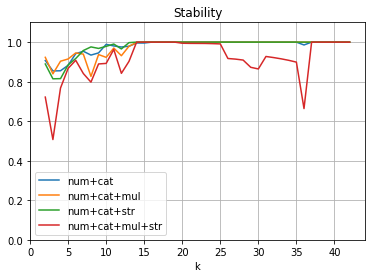

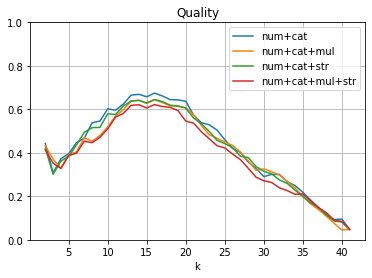

In [37]:
type_combis = ["num+cat", "num+cat+mul", "num+cat+str", "num+cat+mul+str"]
pd.DataFrame({
    type_combi: metrics_types[type_combi]["stabilities"]
    for type_combi in type_combis
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    type_combi: metrics_types[type_combi]["qualities"]
    for type_combi in type_combis
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)